In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
from statsmodels.api import stats
import statsmodels
import statsmodels.sandbox.stats.multicomp
import pandas as pd
from sklearn.utils import shuffle
import hashlib
import warnings
warnings.filterwarnings("ignore")

In [2]:
with open('cookie_cats.csv') as csv:
    data = pd.read_csv(csv)

Проведен А/Б тест между двумя группами. Группа А получает уведомление о необходимости сделать перерыв или осуществить внутриигровую покупку на 30-м уровне, группа Б - на 40-м.

Изучаем как это различие сказывается на уровне retention игроков

In [108]:
data

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True
...,...,...,...,...,...
90184,9999441,gate_40,97,True,False
90185,9999479,gate_40,30,False,False
90186,9999710,gate_30,28,True,False
90187,9999768,gate_40,51,True,False


In [109]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [4]:
data.userid.nunique()

90189

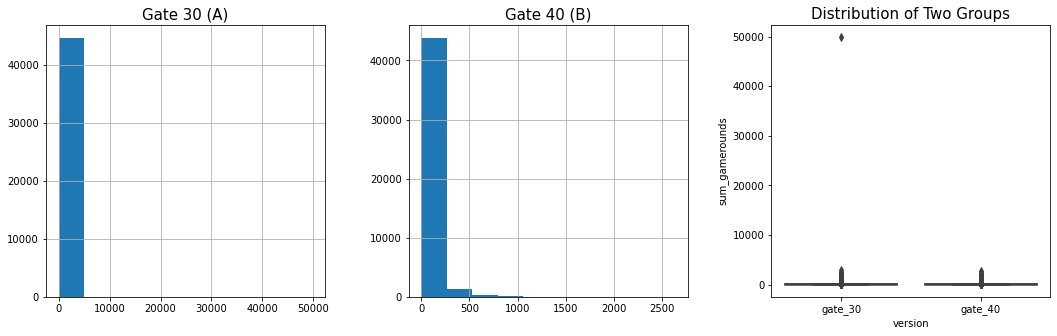

In [110]:
fig, axes = plt.subplots(1, 3, figsize = (18,5))

data[data.version == 'gate_30'].hist('sum_gamerounds', ax = axes[0])
data[data.version == 'gate_40'].hist('sum_gamerounds', ax = axes[1])
sns.boxplot(x = data.version, y = data.sum_gamerounds, ax = axes[2])

axes[0].set_title("Gate 30 (A)", fontsize = 15)
axes[1].set_title("Gate 40 (B)", fontsize = 15)
axes[2].set_title("Distribution of Two Groups", fontsize = 15);

Убираем выбросы

In [3]:
data[(data.version == 'gate_30') & (data.sum_gamerounds > 40000)]

,userid,version,sum_gamerounds,retention_1,retention_7
57702,6390605,gate_30,49854,False,True


In [4]:
data = data[data.sum_gamerounds < 40000]

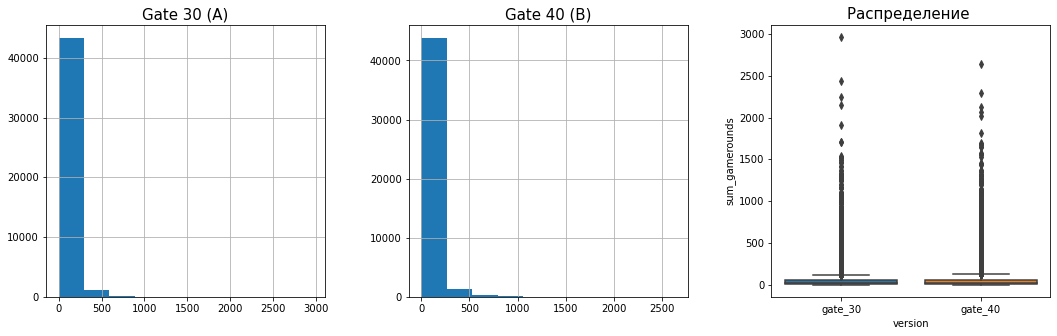

In [5]:
fig, axes = plt.subplots(1, 3, figsize = (18,5))

data[data.version == 'gate_30'].hist('sum_gamerounds', ax = axes[0])
data[data.version == 'gate_40'].hist('sum_gamerounds', ax = axes[1])
sns.boxplot(x = data.version, y = data.sum_gamerounds, ax = axes[2])

axes[0].set_title("Gate 30 (A)", fontsize = 15)
plt.savefig('10.png')
axes[1].set_title("Gate 40 (B)", fontsize = 15)
plt.savefig('11.png')
axes[2].set_title("Распределение ", fontsize = 15)
plt.savefig('12.png');

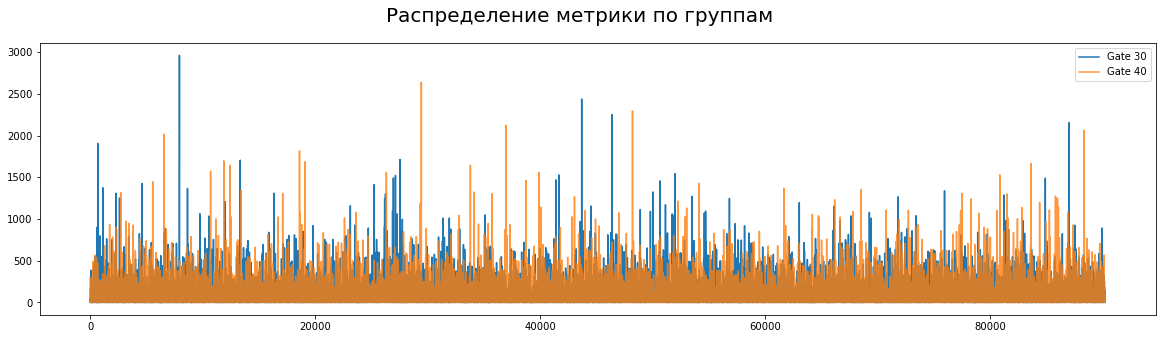

In [6]:
data[(data.version == "gate_30")].sum_gamerounds.plot(legend = True, label = "Gate 30", figsize = (20,5))
data[(data.version == "gate_40")].sum_gamerounds.plot(legend = True, label = "Gate 40", alpha = 0.8)
plt.suptitle("Распределение метрики по группам", fontsize = 20)
plt.savefig('13.png');

In [47]:
data[(data.sum_gamerounds == 0)]

,userid,version,sum_gamerounds,retention_1,retention_7
6,1066,gate_30,0,False,False
11,2101,gate_30,0,False,False
26,3095,gate_30,0,False,False
35,4076,gate_40,0,False,False
37,4176,gate_30,0,False,False
...,...,...,...,...,...
90067,9986185,gate_30,0,False,False
90093,9988600,gate_40,0,False,False
90116,9990773,gate_30,0,False,False
90147,9994604,gate_30,0,False,False


По данным видно, что 3994 юзера не играли в игру, а большинство игроков сыграли только в начальные уровни и не продвинулись дальше

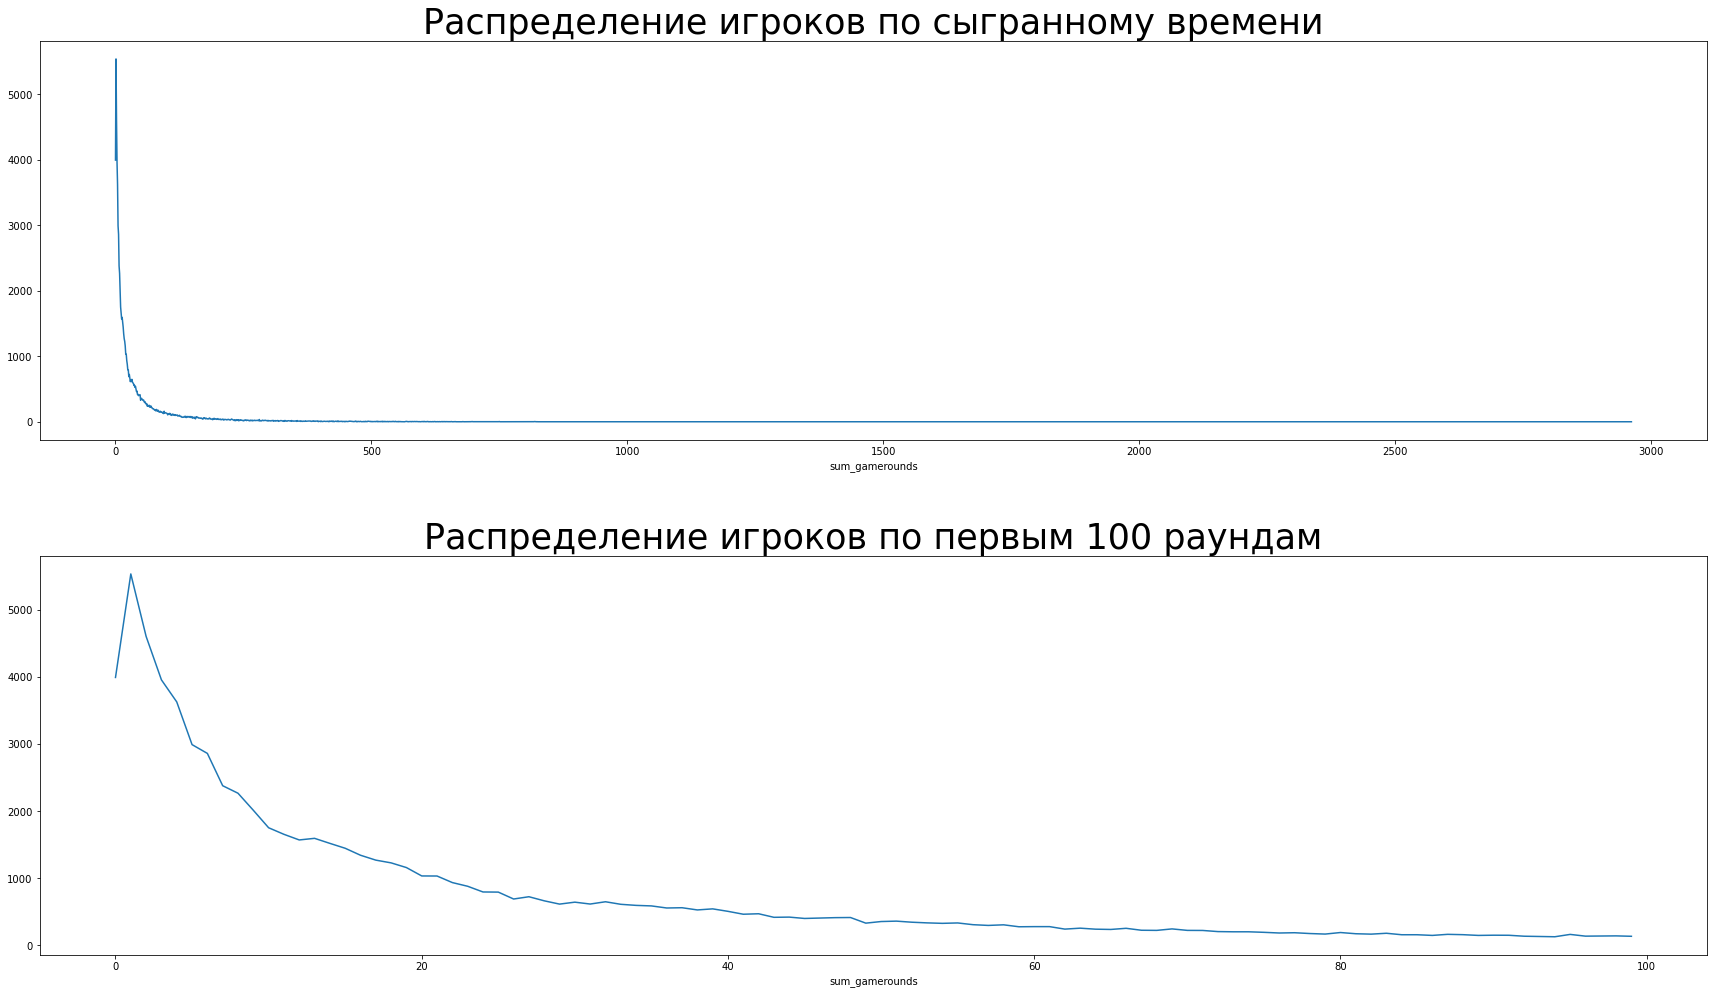

In [7]:
fig, axes = plt.subplots(2, 1, figsize = (25,15))
data.groupby("sum_gamerounds").userid.count().plot(ax = axes[0])
data.groupby("sum_gamerounds").userid.count()[:100].plot(ax = axes[1])
axes[0].set_title("Распределение игроков по сыгранному времени", fontsize = 35)
axes[1].set_title("Распределение игроков по первым 100 раундам", fontsize = 35)
plt.tight_layout(pad=5)
plt.savefig('14.png');

In [112]:
data.groupby("sum_gamerounds").userid.count().reset_index().loc[[30, 40]]

,sum_gamerounds,userid
30,30,642
40,40,505


User retention

In [113]:
pd.DataFrame({"ret_1_day_count": data["retention_1"].value_counts(),
              "ret_7_day_count": data["retention_7"].value_counts(),
              "ret_1_day_ration": data["retention_1"].value_counts() / len(data),
              "ret_7_day_ration": data["retention_7"].value_counts() / len(data)})

,ret_1_day_count,ret_7_day_count,ret_1_day_ration,ret_7_day_ration
False,50036,73408,0.55479,0.813935
True,40153,16781,0.44521,0.186065


In [67]:
data.groupby(['version', 'retention_1']).agg({'sum_gamerounds': ['count', 'min', 'max', 'median', 'mean', 'std']})

sum_gamerounds                                        
                             count min   max median       mean         std
version retention_1                                                       
gate_30 False                24665   0  1072      6  16.359092   36.528426
        True                 20034   0  2961     48  94.411700  135.037697
gate_40 False                25370   0  1241      6  16.340402   35.925756
        True                 20119   0  2640     49  95.381182  137.887256

In [68]:
data.groupby(['version', 'retention_7']).agg({'sum_gamerounds': ['count', 'min', 'max', 'median', 'mean', 'std']})

sum_gamerounds                                         
                             count min   max median        mean         std
version retention_7                                                        
gate_30 False                36198   0   981     11   25.796508   43.316158
        True                  8501   0  2961    105  160.117516  179.358560
gate_40 False                37210   0  2640     11   25.856356   44.406112
        True                  8279   0  2294    111  165.649837  183.792499

Проверим, есть ли статистически значимая разница между группами, продолжившими играть после 1 и 7 дня

stat = 0.48558586835861206, pvalue = 0.0
pvalue < 0.05, отклоняем гипотезу о нормальности распределения


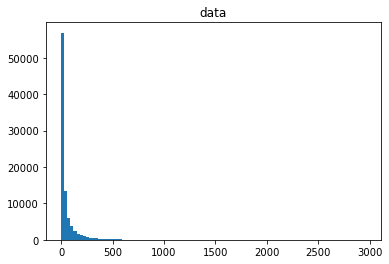

In [69]:
plt.hist(data.sum_gamerounds, bins = 100)
plt.title('data');

stat, pvalue = scipy.stats.shapiro(data.sum_gamerounds)
print(f'stat = {stat}, pvalue = {pvalue}')
print('pvalue < 0.05, отклоняем гипотезу о нормальности распределения');

Сплит

In [114]:
data["version"] = np.where(data.version == "gate_30", "A", "B")

groupA = data[data['version'] == "A"]['sum_gamerounds']
groupB = data[data['version'] == "B"]['sum_gamerounds']

In [117]:
comp_data = stats.Table.from_data(data[['sum_gamerounds', 'version']])

In [118]:
ttest = scipy.stats.mannwhitneyu(groupA, groupB)
ttest

MannwhitneyuResult(statistic=1009027049.5, pvalue=0.025104403860221253)

p-value меньше уровня значимости, отвергаем нулевую гипотезу, группы не одинаковы, есть статистически значимая разница


In [119]:
data.groupby("version").retention_1.mean(), data.groupby("version").retention_7.mean()

(version
 A    0.448188
 B    0.442283
 Name: retention_1, dtype: float64,
 version
 A    0.190201
 B    0.182000
 Name: retention_7, dtype: float64)

Уровень retention выше в группе А (gate_30) выше